# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 16D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 8      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1.2===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

# def invert_prior_lpn(x, model, INVERT_MODE):
#     y = invert(x,model,INVERT_MODE)
#     return y

# def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
#     try:
#         y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
#     except NameError: 
#         print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
#         y_tensor = torch.from_numpy(y_inverted_points).float()
#         psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
#     prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
#     return prior_est


def evaluate_learned_J_HJ_approx(x_eval_points_np, model, t_val=1.0):
    """
    Evaluates the learned prior J_est(x) using the LPN and HJ approximation.
    J(x) ≈ S(x + t*grad_S(x,t), t) - (t/2)*||grad_S(x,t)||^2
    where S(x,t) = (1/2t)||x||^2 - (1/t)psi_t(x) if LPN learns psi_t(x).
    Here, LPN learns psi(x) which is psi_1(x), so we use t=1.
    S(x,1) = 0.5*||x||^2 - psi(x)
    grad_S(x,1) = x - grad_psi(x)
    
    Args:
        x_eval_points_np (np.ndarray): N x dim array of points to estimate J(x) at.
        model: The trained LPN model object (e.g., a torch.nn.Module).
        t_val (float): Time parameter, typically 1.0 for this setup.
    
    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    x_tensor = torch.from_numpy(x_eval_points_np).float().to(device)
    x_tensor.requires_grad_(True)  # Ensure grad can be computed
    
    # grad_psi_x = nabla_psi(x)
    # The LPN's forward() method (model(x_tensor)) should return nabla_psi(x)
    grad_psi_x_tensor = model(x_tensor) 
    
    # p_eval = nabla_S(x,1) = x - nabla_psi(x)
    p_eval_tensor = x_tensor - grad_psi_x_tensor
    
    # x_new = x + t * p_eval
    x_new_tensor = x_tensor + t_val * p_eval_tensor
    
    # psi_x_new = psi(x_new)
    psi_x_new_tensor = model.scalar(x_new_tensor)  # Should be N x 1
    
    # S(x_new, 1) = 0.5*||x_new||^2 - psi(x_new)
    norm_sq_x_new_tensor = torch.sum(x_new_tensor**2, dim=1, keepdim=True)  # N x 1
    S_x_new_t_tensor = 0.5 * norm_sq_x_new_tensor - psi_x_new_tensor  # N x 1
    
    # (t/2)*||p_eval||^2
    norm_sq_p_eval_tensor = torch.sum(p_eval_tensor**2, dim=1, keepdim=True)  # N x 1
    term2_tensor = (t_val / 2.0) * norm_sq_p_eval_tensor  # N x 1
    
    J_approx_tensor = S_x_new_t_tensor - term2_tensor  # N x 1
    
    return J_approx_tensor.detach().cpu().numpy().flatten()  # N-dimensional

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    #y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        #y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), cvx_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l2 = torch.optim.Adam(lpn_model_quad_l2.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

for g in optimizer_quad_l2.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_quad_l2.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

torch.save(lpn_model_quad_l2.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l2.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 605.4747314453125
iteration 0 loss 58378516.0


iteration 5000 loss 2446.3642578125


iteration 10000 loss 17.490243911743164


iteration 15000 loss 6.995782375335693


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 3.8233468532562256


iteration 25000 loss 1.7492804527282715


iteration 30000 loss 0.46657252311706543


iteration 35000 loss 0.27913549542427063


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.20195624232292175


iteration 45000 loss 0.19392652809619904


iteration 50000 loss 0.17665231227874756


iteration 55000 loss 0.16050846874713898


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.14598210155963898


iteration 65000 loss 0.14411073923110962


iteration 70000 loss 0.1420135498046875


iteration 75000 loss 0.13995316624641418


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.13793043792247772


iteration 85000 loss 0.137735053896904


iteration 90000 loss 0.1375398486852646


iteration 95000 loss 0.1373451054096222


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---


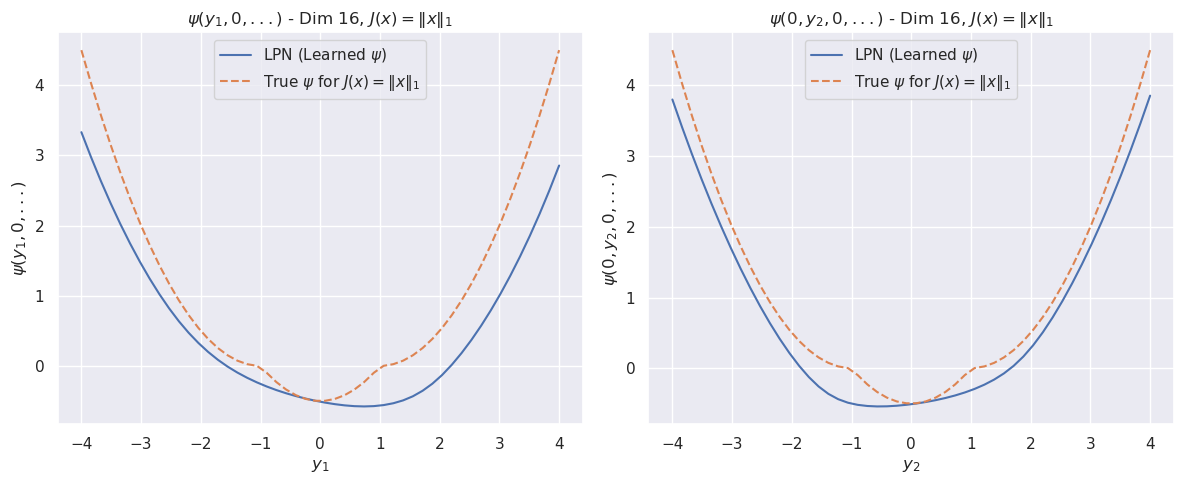

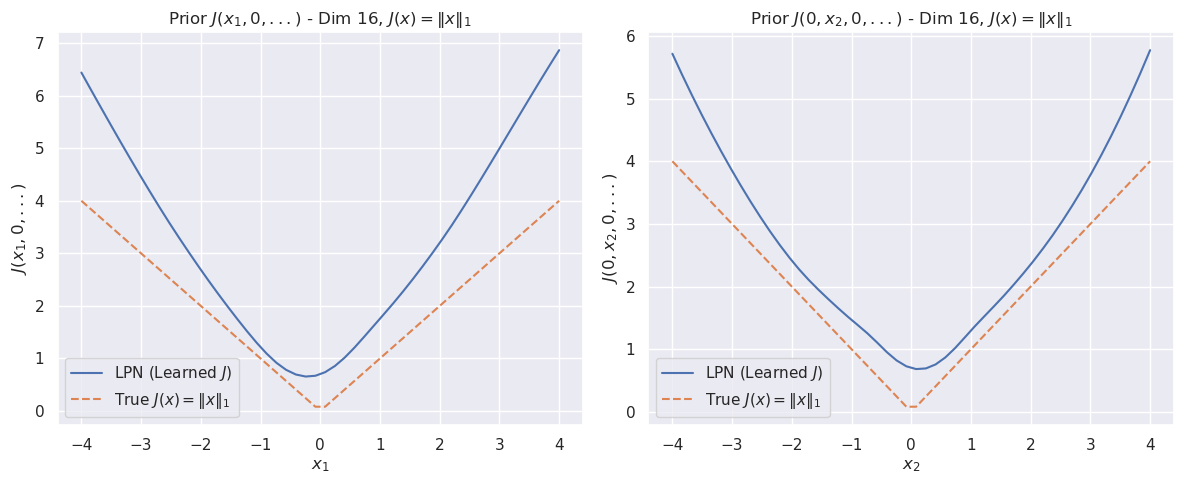

In [8]:
# L2 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_quadratic_l1(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_quadratic_l1(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 673.07421875
iteration 0 loss 16778132.0


iteration 5000 loss 368.59747314453125


iteration 10000 loss 4.099545001983643


iteration 15000 loss 3.1602771282196045


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 1.2035515308380127


iteration 25000 loss 0.37100207805633545


iteration 30000 loss 0.1618902087211609


iteration 35000 loss 0.09560669213533401


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.07182326167821884


iteration 45000 loss 0.06855976581573486


iteration 50000 loss 0.06325656175613403


iteration 55000 loss 0.058764055371284485


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.05481652170419693


iteration 65000 loss 0.05426350235939026


iteration 70000 loss 0.053386565297842026


iteration 75000 loss 0.05252744257450104


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.05169729143381119


iteration 85000 loss 0.051607903093099594


iteration 90000 loss 0.05151621997356415


iteration 95000 loss 0.05142495036125183


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


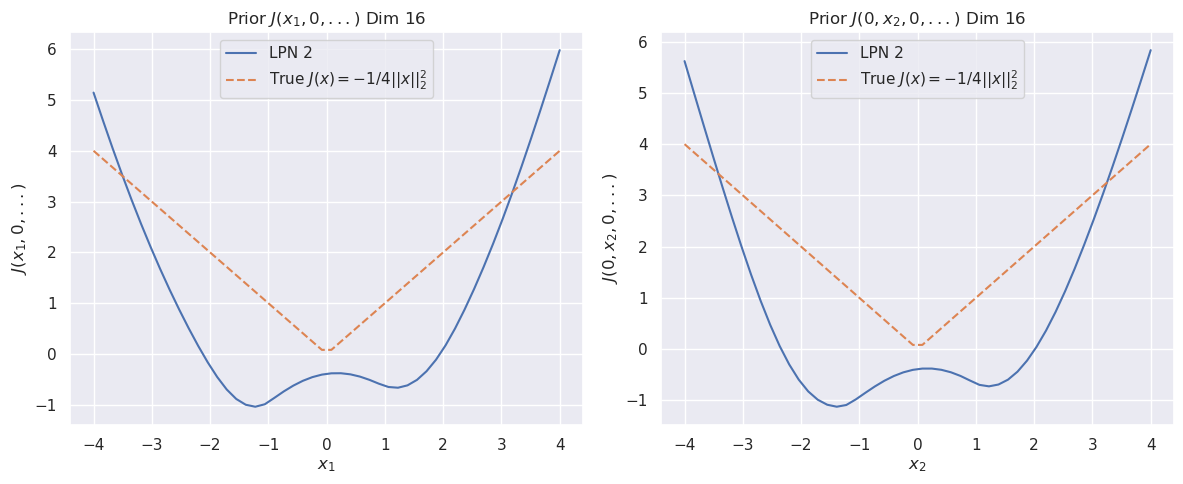

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
   # plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 24.403867721557617
iteration 0 loss 5653.12890625


iteration 5000 loss 2.0306694507598877


iteration 10000 loss 0.4451912045478821


iteration 15000 loss 0.3571923077106476


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.3219510316848755


iteration 25000 loss 0.3092081546783447


iteration 30000 loss 0.3041585385799408


iteration 35000 loss 0.2997382879257202


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.29460033774375916


iteration 45000 loss 0.2934812307357788


iteration 50000 loss 0.29280227422714233


iteration 55000 loss 0.29229792952537537


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.29182523488998413


iteration 65000 loss 0.2916741669178009


iteration 70000 loss 0.2916170060634613


iteration 75000 loss 0.29155436158180237


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.29149994254112244


iteration 85000 loss 0.2914811372756958


iteration 90000 loss 0.2914772927761078


iteration 95000 loss 0.29147422313690186


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---


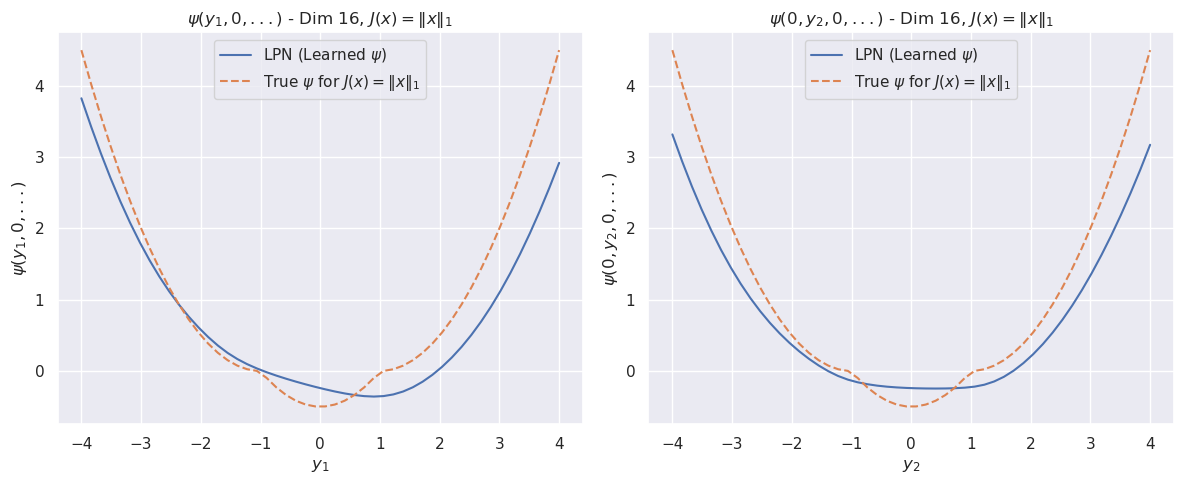

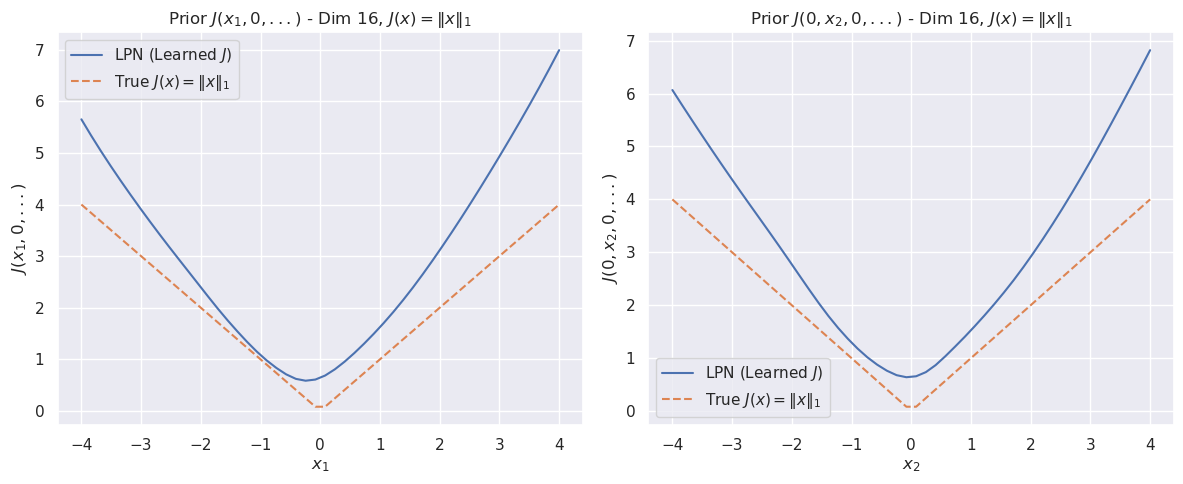

In [13]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


In [14]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([30000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 678.4503784179688
iteration 0 loss 13358904.0


iteration 5000 loss 238.16783142089844


iteration 10000 loss 4.320207118988037


iteration 15000 loss 3.1928584575653076


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 1.2580269575119019


iteration 25000 loss 0.395904541015625


iteration 30000 loss 0.17066222429275513


iteration 35000 loss 0.10229130834341049


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.07587998360395432


iteration 45000 loss 0.07144036889076233


iteration 50000 loss 0.06546807289123535


iteration 55000 loss 0.060548026114702225


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.05627736821770668


iteration 65000 loss 0.05559796839952469


iteration 70000 loss 0.05465755611658096


iteration 75000 loss 0.05374838039278984


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.052867356687784195


iteration 85000 loss 0.05277334898710251


iteration 90000 loss 0.052677277475595474


iteration 95000 loss 0.05258166790008545


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


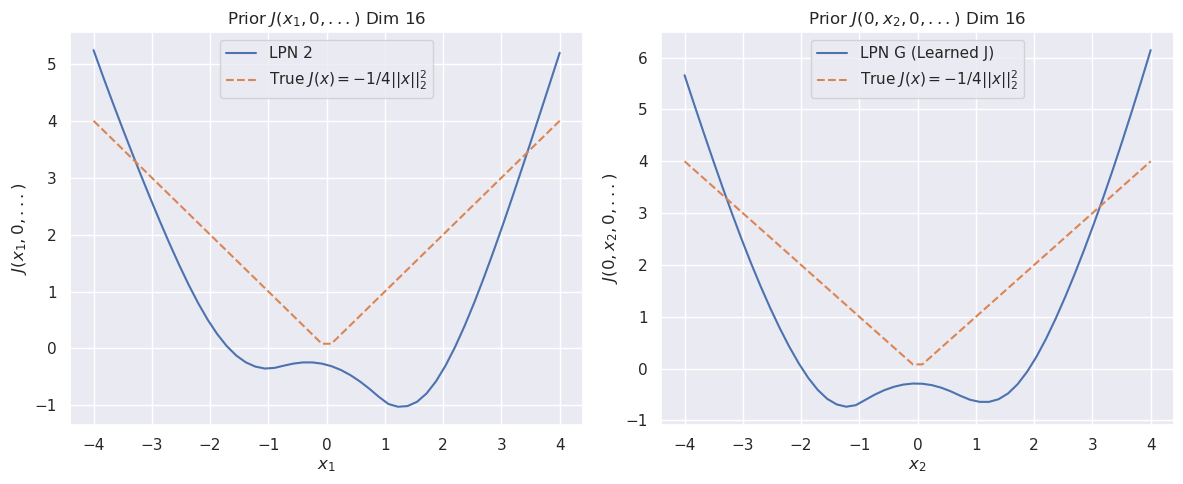

In [15]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)